In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import pickle
from scipy.interpolate import interp1d
import imageio.v2 as imageio
from pathlib import Path
import h5py
from scipy.io import savemat
import scipy.integrate as integrate

from src.data.file_utils import GetTV


In [5]:
def nearest_index(array, value):
    """Find the index of the nearest value in an array."""
    return (np.abs(array - value)).argmin()

def crop_time(times, data, start_time, end_time):
    """Crop the data to the specified time range."""
    if data.ndim == 1:
        data = data.reshape(1, -1)
    start_idx = nearest_index(times, start_time)
    end_idx = nearest_index(times, end_time)
    return times[start_idx:end_idx], data[:,start_idx:end_idx]

def get_index(arr, coord):
    # Get the insertion indices
    ind = np.searchsorted(coord, arr)

    # Correct the indices to point to the nearest actual index
    ind = np.clip(ind, 0, len(coord) - 1)

    # Now, adjust the indices to get the closest value
    for i, cval in enumerate(arr):
        if ind[i] > 0 and abs(cval - coord[ind[i] - 1]) < abs(cval - coord[ind[i]]):
            ind[i] -= 1
            
    return ind

In [6]:
tv = GetTV('../data/raw/tv_images/all')
files = tv.list_files()
for idx, file in enumerate(files):
    print(idx, '\t',file.stem.split('_')[-1])

0 	 189057
1 	 189061
2 	 189062
3 	 189081
4 	 189088
5 	 189090
6 	 189093
7 	 189094
8 	 189097
9 	 189100
10 	 189101
11 	 189448
12 	 189451
13 	 190109
14 	 190110
15 	 190113
16 	 190114
17 	 190115
18 	 190116
19 	 199166
20 	 199171
21 	 199172
22 	 199351
23 	 199352
24 	 199353
25 	 199354


In [36]:
file_idx = 19
print('Extracting sav for shot:', files[file_idx].stem.split('_')[-1])

[inverted,radii,elevation,frames,times,vid_frames,vid_times,vid] = tv.load_all(files[file_idx])
inverted_times = vid_times[frames.astype(int)]
inverted_dim = inverted.shape
if (inverted_dim[1] != 201) or (inverted_dim[2] != 201):
    print('Resizing...')
    inverted = inverted[:,:201,:201]
    radii = radii[:,:201]
    elevation = elevation[:,:201]
    inverted_dim = inverted.shape

Extracting sav for shot: 199166
Resizing...


In [37]:
scaling_factor = 10
radii_hires = np.linspace(radii[0][0],radii[0][-1],len(radii[0])*scaling_factor)
elevation_hires = np.linspace(elevation[0][0],elevation[0][-1],len(elevation[0])*scaling_factor)

In [38]:
pkl_path = '../data/external/toksearch/detach.pkl'

with open(pkl_path, 'rb') as file:
    points = pickle.load(file)

point_keys = list(points.keys())
shot = points[point_keys[file_idx]]['vars']
times = points[point_keys[file_idx]]['time']
times_transp = np.transpose(times)
shot_transp = np.transpose(shot)
print("Extracting pkl for shot: ", point_keys[file_idx])

Extracting pkl for shot:  199166


In [39]:
crop_times, crop_shot = crop_time(times_transp, shot_transp, inverted_times[0], inverted_times[-1])
rx = crop_shot[0] / 1e2
zx = crop_shot[1] / 1e2
rs = crop_shot[2] / 1e2
zs = crop_shot[3] / 1e2

interp_kind = 'linear'
rx_interp = interp1d(crop_times, rx, kind=interp_kind,fill_value='extrapolate')(inverted_times)
zx_interp = interp1d(crop_times, zx, kind=interp_kind,fill_value='extrapolate')(inverted_times)
rs_interp = interp1d(crop_times, rs, kind=interp_kind,fill_value='extrapolate')(inverted_times)
zs_interp = interp1d(crop_times, zs, kind=interp_kind,fill_value='extrapolate')(inverted_times)

In [40]:
rx_idx = get_index(rx_interp, radii_hires) / scaling_factor
zx_idx = get_index(zx_interp, elevation_hires) / scaling_factor
zs_idx = get_index(zs_interp, elevation_hires) / scaling_factor

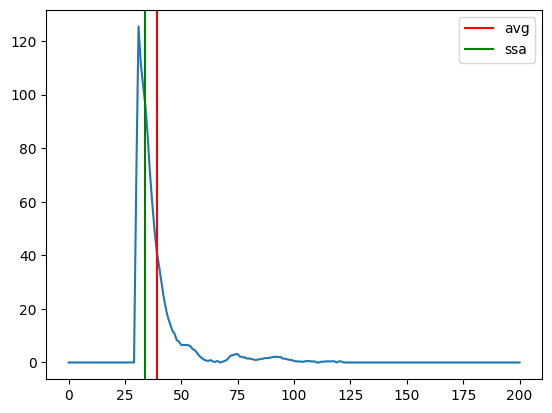

In [41]:
idx = 5
inverted_img = inverted[idx]
filter_img = (inverted_img > 0.1) * inverted_img
r = np.round(rx_idx[idx]).astype(int)
sum_outer = np.sum(filter_img[:,r:],axis=1)
indicies = np.arange(0, filter_img.shape[0])
weighted_sum = np.sum(indicies * sum_outer)
weighted_squre_sum = np.sum((indicies * sum_outer)**2)
total_weight = np.sum(sum_outer)
total_square_weight = np.sum(sum_outer**2)
avg = weighted_sum / total_weight
sqrt_sum_sq_avg = (weighted_squre_sum / total_square_weight)**0.5

plt.plot(sum_outer)
plt.axvline(avg,c='r', label='avg')
plt.axvline(sqrt_sum_sq_avg,c='g', label='ssa')
plt.legend()
plt.show()

In [42]:
z_arr_avg = []
z_arr_ssa = []
for idx, inverted_img in enumerate(inverted):
    filter_img = (inverted_img > 0.1) * inverted_img
    r = np.round(rx_idx[idx]).astype(int)
    sum_outer = np.sum(filter_img[:,r:],axis=1)
    indicies = np.arange(0, filter_img.shape[0])
    
    weighted_sum = np.sum(indicies * sum_outer)
    avg = np.divide(weighted_sum, np.sum(sum_outer), out=np.empty_like(weighted_sum), where=np.sum(sum_outer)!=0)
    z_arr_avg.append(avg)
    
    weighted_square_sum = np.sum((indicies * sum_outer)**2)
    total_square_weight = np.sum(sum_outer**2)
    sqrt_sum_sq_avg = np.divide(weighted_square_sum, total_square_weight, out=np.empty_like(weighted_square_sum), where=total_square_weight!=0)**0.5
    z_arr_ssa.append(sqrt_sum_sq_avg)

z_arr_avg = np.asarray(z_arr_avg)
z_arr_ssa = np.asarray(z_arr_ssa)
avg_avg_idx = np.mean(z_arr_avg)
ssa_avg_idx = np.mean(z_arr_ssa)
z_arr_avg[np.where(z_arr_avg == 0)[0]] = avg_avg_idx
z_arr_ssa[np.where(z_arr_ssa == 0)[0]] = ssa_avg_idx

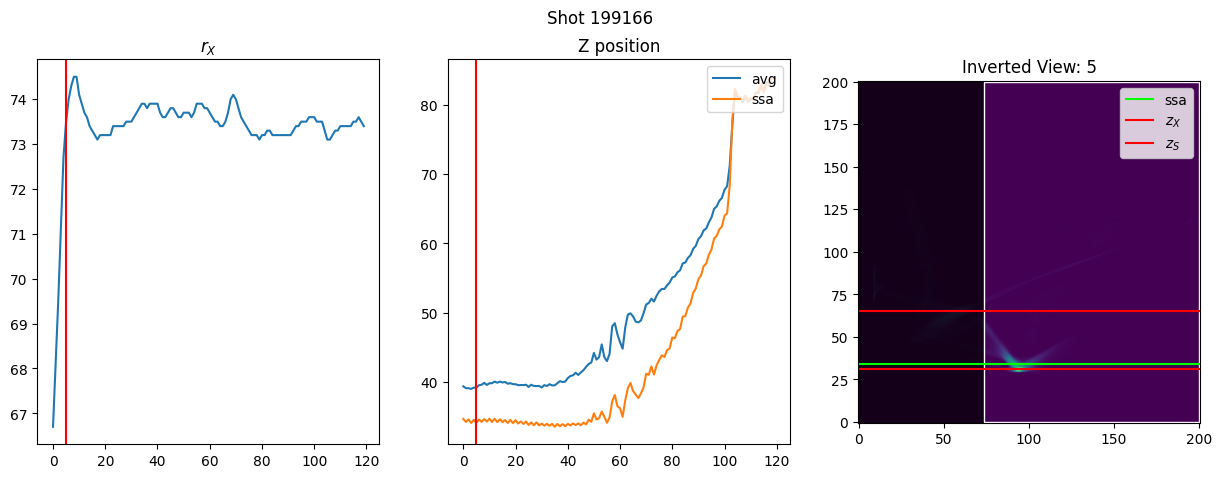

In [43]:
shot_length = inverted_dim[0]
idx = 5

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

rect = patches.Rectangle((rx_idx[idx], 0), inverted_dim[1]-rx_idx[idx]-1, inverted_dim[2]-1, linewidth=1, edgecolor='w', facecolor='none')

ax_idx = 0
ax[ax_idx].plot(rx_idx)
ax[ax_idx].axvline(idx, color='r')
ax[ax_idx].set_title('$r_X$')

ax_idx = 1
ax[ax_idx].plot(z_arr_avg, label='avg')
ax[ax_idx].plot(z_arr_ssa, label='ssa')
ax[ax_idx].axvline(idx, color='r')
ax[ax_idx].legend(loc='upper right')
ax[ax_idx].set_title('Z position')

ax_idx = 2
ax[ax_idx].imshow(inverted[idx], origin='lower')
ax[ax_idx].axvspan(0, rx_idx[idx], color='black', alpha=0.7)
ax[ax_idx].set_title(f'Inverted View: {idx}')
ax[ax_idx].add_patch(rect)
ax[ax_idx].axhline(z_arr_ssa[idx],c='lime', label='ssa')
ax[ax_idx].axhline(zx_idx[idx],c='r', label='$z_X$')
ax[ax_idx].axhline(zs_idx[idx],c='r', label='$z_S$')
ax[ax_idx].legend(loc='upper right')

fig.suptitle(f"Shot {files[file_idx].stem.split('_')[-1]}")

fig.show()

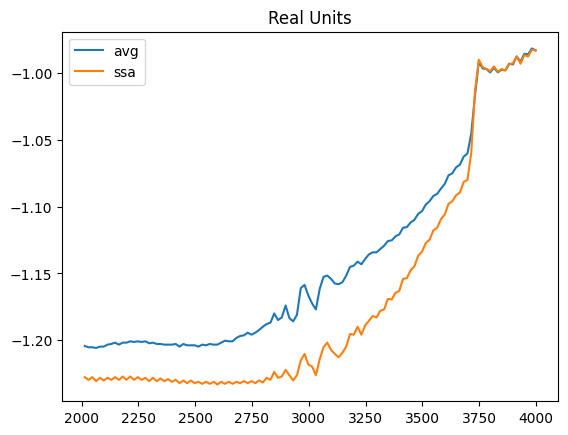

In [44]:
z_avg_rounds = [z*scaling_factor for z in z_arr_avg]
z_ssa_rounds = [z*scaling_factor for z in z_arr_ssa]

z_avg_real = elevation_hires[np.round(z_avg_rounds).astype(int)]
z_ssa_real = elevation_hires[np.round(z_ssa_rounds).astype(int)]

plt.plot(inverted_times,z_avg_real, label='avg')
plt.plot(inverted_times,z_ssa_real, label='ssa')
plt.title('Real Units')
plt.legend()
plt.show()

# System Identification
Do this after doing weighted_prediction_ml

In [15]:
value_path = Path('../data/processed/') / 'weight_ml_point'
pkl_files = sorted(value_path.glob('*.pkl'))
tv = GetTV('../data/raw/tv_images/all')
files = tv.list_files()
for idx, file in enumerate(pkl_files):
    print(idx, '\t', file.stem.split('_')[-1])

0 	 189057
1 	 189061
2 	 189062
3 	 189081
4 	 189088
5 	 189090
6 	 189093
7 	 189094
8 	 189097
9 	 189100
10 	 189101
11 	 189448
12 	 189451
13 	 190109
14 	 190110
15 	 190113
16 	 190114
17 	 190115
18 	 190116
19 	 199166
20 	 199171
21 	 199172
22 	 199351
23 	 199352
24 	 199353
25 	 199354


In [30]:
file_idx = 21

In [31]:
h5_path = '../data/external/toksearch/detach.h5'
shot = str(pkl_files[file_idx].stem.split('_')[-1])
with h5py.File(h5_path, 'r') as file:
    print(file.keys())
    for key in file.keys():
        print(file[key].keys())
        break
    h5_times = file['times'][:]
    gasA = file[shot]['gasA'][:]
    gasB = file[shot]['gasB'][:]
    gasC = file[shot]['gasC'][:]
    dssdenest = file[shot]['dssdenest'][:]
    ip = file[shot]['ip'][:]
    t_ip_flat_sql = file[shot]['t_ip_flat_sql'][()]
    ip_flat_duration_sql = file[shot]['ip_flat_duration_sql'][()]
    ZXPT1_EFIT01 = file[shot]['ZXPT1_EFIT01'][:]
    # dstradpg2 = file[shot]['dstradpg2'][:]

<KeysViewHDF5 ['189057', '189061', '189062', '189081', '189088', '189090', '189093', '189094', '189097', '189100', '189101', '189448', '189451', '190109', '190110', '190113', '190114', '190115', '190116', '195954', '195956', '195959', '195961', '195963', '199166', '199171', '199172', '199351', '199352', '199353', '199354', 'spatial_coordinates', 'times']>
<KeysViewHDF5 ['Ar_tot', 'D_tot', 'H_tot', 'He_tot', 'N_tot', 'Ne_tot', 'ZXPT1_EFIT01', 'betan_EFIT01', 'betap_EFIT01', 'bt', 'dssdene', 'dssdenest', 'dstradpg2', 'gasA', 'gasB', 'gasC', 'gas_sql', 'ip', 'ip_flat_duration_sql', 'pcphd03', 'q0_EFIT01', 'q95_EFIT01', 'qmin_EFIT01', 't_ip_flat_sql', 'thomson_density_psi_raw_1d', 'thomson_density_raw_1d', 'thomson_density_uncertainty_raw_1d', 'thomson_temp_psi_raw_1d', 'thomson_temp_raw_1d', 'thomson_temp_uncertainty_raw_1d', 'valve_sql']>


In [32]:
[inverted,radii,elevation,frames,times,vid_frames,vid_times,vid] = tv.load_all(files[file_idx])

with open(pkl_files[file_idx], 'rb') as file:
    data = pickle.load(file)
    print(pkl_files[file_idx].stem)

emission_structure_pu_cam240perp_199172


In [33]:
t_start = t_ip_flat_sql
t_end = t_ip_flat_sql + ip_flat_duration_sql

t_grid = np.linspace(t_start, t_end, 1000)
crop_h5_times, crop_gasA = crop_time(h5_times, gasA, t_start, t_end)
_, crop_ZXPT1_EFIT01 = crop_time(h5_times, ZXPT1_EFIT01, t_start, t_end)
_, crop_ip = crop_time(h5_times, ip, t_start, t_end)
_, crop_dssdenest = crop_time(h5_times, dssdenest, t_start, t_end)
crop_times, crop_data = crop_time(vid_times, data, t_start, t_end)
interp_kind = 'cubic'
interp_ZXPT = interp1d(crop_h5_times, crop_ZXPT1_EFIT01, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_data = interp1d(crop_times, crop_data, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_gasA = interp1d(crop_h5_times, crop_gasA, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_ip = interp1d(crop_h5_times, crop_ip, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_dssdenest = interp1d(crop_h5_times, crop_dssdenest, kind=interp_kind, fill_value='extrapolate')(t_grid)

gasA_PID = interp_gasA[0]
interp_ZStrike = np.ones_like(interp_ZXPT) * -1.24477
Dz = (interp_ZXPT - interp_data) / (interp_ZXPT - interp_ZStrike) + interp_ZStrike
Dz_PID = Dz[0]

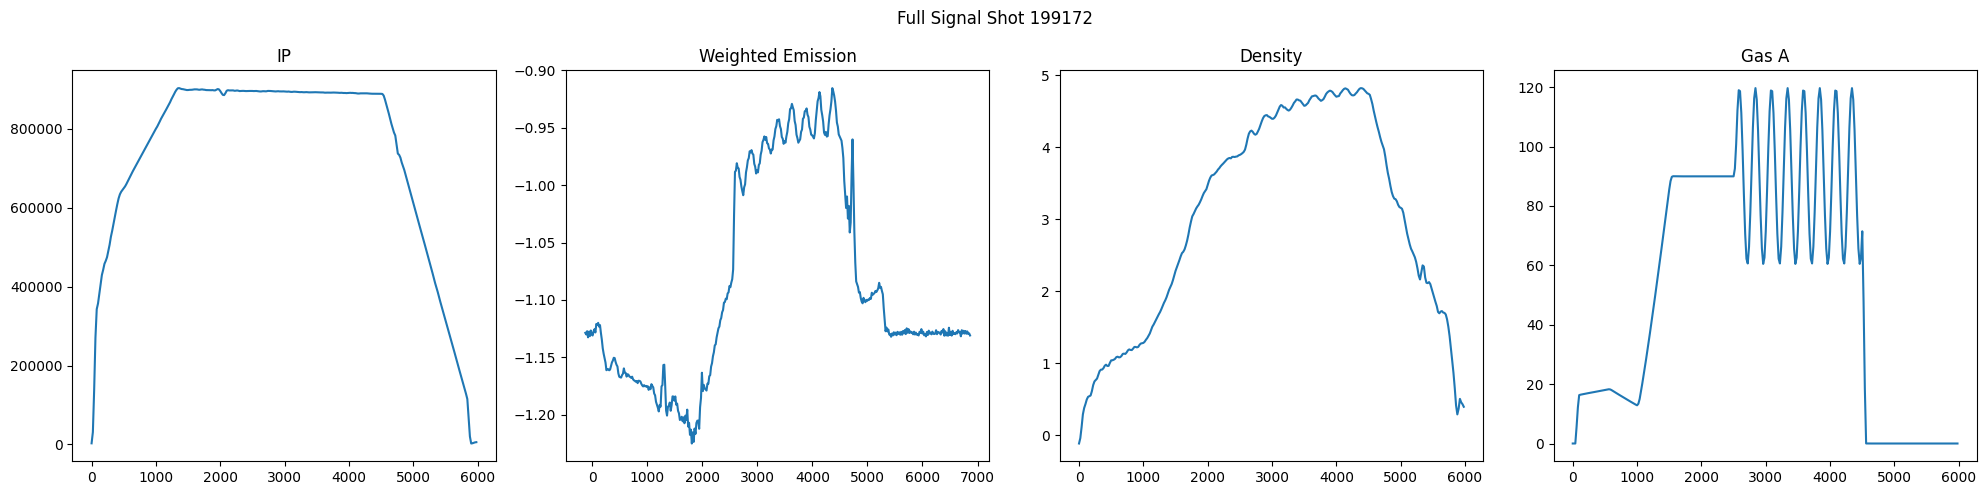

In [34]:
plt.figure(figsize=(20,5))

plt.subplot(1, 4, 1)
plt.plot(h5_times, ip)
plt.title('IP')

plt.subplot(1, 4, 2)
plt.plot(vid_times,data)
plt.title('Weighted Emission')

plt.subplot(1, 4, 3)
plt.plot(h5_times, dssdenest)
plt.title('Density')

plt.subplot(1, 4, 4)
plt.plot(h5_times, gasA)
plt.title('Gas A')

plt.suptitle(f"Full Signal Shot {shot}")
plt.tight_layout()

plt.show()

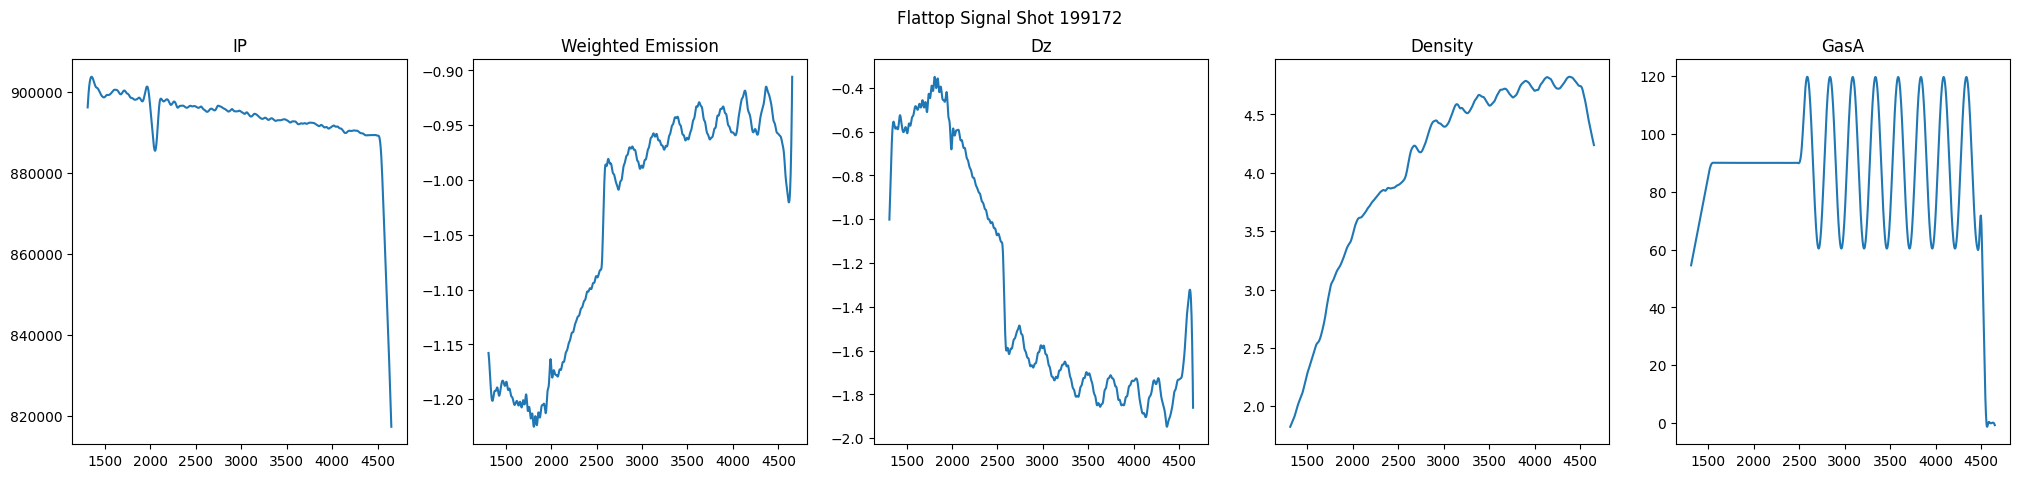

In [35]:
plt.figure(figsize=(25,5))
plt.subplot(1, 5, 2)
plt.plot(t_grid,interp_data[0])
plt.title('Weighted Emission')
plt.subplot(1, 5, 4)
plt.plot(t_grid, interp_dssdenest[0])
plt.title('Density')
plt.subplot(1, 5, 5)
plt.plot(t_grid, gasA_PID)
plt.title('GasA')
plt.subplot(1, 5, 3)
plt.plot(t_grid, Dz_PID)
plt.title('Dz')
plt.subplot(1, 5, 1)
plt.plot(t_grid, interp_ip[0])
plt.title('IP')
plt.suptitle('Flattop Signal Shot ' + shot)
plt.tight_layout
plt.show()

In [36]:
txt_file = (Path('../data/processed/weight_ml_point') / files[file_idx].stem.split('_')[-1]).with_suffix('.txt')
with open(txt_file, 'w') as f:
    for idx, point in enumerate(gasA_PID):
        f.write(f"{t_grid[idx]}, {Dz_PID[idx]}, {point}\n")
print(f"Saved {txt_file}")

Saved ../data/processed/weight_ml_point/199172.txt
